<a href="https://colab.research.google.com/github/oscarserc/TESIS/blob/main/PASO_3b___CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UTILIZACIÓN DE TÉCNICAS DE APRENDIZAJE AUTOMÁTICO PARA LA DETECCIÓN DE LOS NODOS INFLUYENTES.

La base de datos que emplearemos será de unas 70.000 observaciones. En concreto:

· 72.000 observaciones

· Para ello generamos una 1800 **simulaciones**, y guardamos unos 40 **frames** de cada una de ellas

· Además como **target** guardamos la matriz con la IDENTIDAD de todos y cada uno de los AGENTES.



#**PRUEBA 2**: Utilizaremos una <font color='green'>**RED NEURONAL CONVOLUCIONAL**</font>. Planteamos el problema de localizar a los agentes influyentes como un problema de **Segmentación** de imágenes. (Cada pixel corresponde a un agente y ha de ser clasificado en uno de los tipos que se han definico)

La estructura que hemos probado de partida es la que aparece a continuación.


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/CNN_1h_%20ampliado.png?raw=true' width="850"/>
<figcaption>fig. 1: En esta primera prueba manejamos sólo dos tipos de agentes: <b>Agente EMOCIONAL</b> y <b>Agente MUTANTE TRAIDOR</b>. Por ello el problema se trata de uno de CLASIFICACIÓN BINARIA. Cada pixel ha de ser marcado como perteneciente a una población u otra. La salida de la red son dos matrices de 10x10 con la probabilidad de pertenencia a cada clase.</figcaption></center>
</figure>


El archivo de prueba contiene 4000 simulaciones de una población de AGENTES EMOCIONALES, y otras 4000 de agentes TRAIDORES (de la observación 4001 a la 8000).


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Archivo_E_CNN.png?raw=true' width="1000"/>
<figcaption></figcaption></center>
</figure>





Podemos comenzar **aleatorizando**, y después manteniendo agrupadas las observaciones (frames) que forman parte de la misma Simulación (animación).

#CARGA DE LA BASE DE DATOS (mezcla agentes **emocionales** y mutantes **traidores**).

#DESPUÉS ALEATORIZAMOS.

In [ ]:

import pandas as pd

# Cargamos los datos
# ------------------
bd_simulaciones = pd.read_csv('bd_combinado.csv')

# Aleatorizamos
# -------------
bd_simulaciones = bd_simulaciones.sample(frac=1).reset_index(drop=True)



In [ ]:

bd_simulaciones


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b94,b95,b96,b97,b98,b99,Simulacion_ID,Frame,Target,Target_class
0,0.333333,0.2,0.2,0.2,0.2,0.4,0.2,0.0,0.2,0.333333,...,0.2,0.2,0.2,0.2,0.2,0.000000,97,22,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
1,0.333333,0.4,0.4,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,...,0.2,0.2,0.2,1.0,0.4,0.333333,50,19,"[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
2,0.333333,0.2,0.2,0.2,0.4,0.6,0.4,0.2,0.4,0.333333,...,0.4,0.0,0.0,0.0,0.0,0.000000,39,37,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ...",1
3,0.333333,0.4,0.2,0.4,0.4,0.6,0.2,0.6,0.4,0.666667,...,0.2,1.0,1.0,1.0,1.0,0.333333,33,5,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, ...",1
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,25,13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000000,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,90,22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
7996,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,15,10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
7997,0.666667,0.6,0.4,0.4,0.2,0.4,0.2,0.2,0.2,0.333333,...,1.0,0.2,0.0,0.2,1.0,0.666667,21,2,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",1
7998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.2,0.000000,53,36,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


#Variables explicativas: **X**

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

size   = 10
agente = 0
df     = bd_simulaciones.copy()

lista_frames = []
X            = []

nombre_columnas_ROJO  = ['r' + str(indice) for indice in range(size*size)]
nombre_columnas_VERDE = ['g' + str(indice) for indice in range(size*size)]
nombre_columnas_AZUL  = ['b' + str(indice) for indice in range(size*size)]


for fila in range(len(bd_simulaciones)):
  canal_r = pd.array(df[nombre_columnas_ROJO].iloc[fila]).reshape(size,size)
  canal_v = pd.array(df[nombre_columnas_VERDE].iloc[fila]).reshape(size,size)
  canal_a = pd.array(df[nombre_columnas_AZUL].iloc[fila]).reshape(size,size)

  # CUIDADO que np.dstack apila los tres valores de cada pixel
  # ----------------------------------------------------------
  frame = np.array([canal_r, canal_v, canal_a])

  lista_frames.append(frame)

X = np.array(lista_frames)
X.shape


(8000, 3, 10, 10)

#Target: **Y**.

In [ ]:

lista_targets = []

for fila in range(len(bd_simulaciones)):
  lista_id_agentes = bd_simulaciones.iloc[fila]['Target'].replace('[','').replace(']','')
  target = [int(caracter) for caracter in lista_id_agentes.split(',')]
  target = np.array(target)
  target = target.reshape(size,size)

  # Con los paréntesis  '['  ']' sale de dimensión: (8000, 1, 10, 10)   # <-------------------------- Aquí ajusto la DIMENSIÓN
  #lista_targets.append([target])
  # Si queremos de dimensión: (8000, 10, 10)
  lista_targets.append(target)

Y = np.array(lista_targets)
Y.shape


(8000, 10, 10)

#**CONVERSIÓN EN TENSORES DE PyTorch**.

In [ ]:

import numpy as np
import torch

# PRIMERO TENEMOS QUE EXTRAER LA MATRIX:  X
# y los valores del TARGET:               Y
#
# Luego pasaremos (X, Y) al Dataset que creamos a continuación.
# --------------------------------------------------------------

X_train = X
Y_train = Y

# CREAMOS UNA CLASE PARA LOS DATOS
# ================================

class Dataset_frames(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X).float()
    self.Y = torch.tensor(Y).long()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return self.X[ix], self.Y[ix]


# SELECCIONANDO GRUPOS DE OBSERVACIONES PARA VALIDACIÓN
# -----------------------------------------------------

from sklearn.model_selection import train_test_split

X_subset, X_val, Y_subset, Y_val = train_test_split(X_train, Y_train, test_size = 0.2)

dataset = {
    'train' : Dataset_frames(X_subset, Y_subset),
    'val'   : Dataset_frames(X_val, Y_val)
}

dataloader = {
    'train' : torch.utils.data.DataLoader(dataset['train'], batch_size=40,   shuffle=False),
    'val'   : torch.utils.data.DataLoader(dataset['val'],   batch_size=40, shuffle=False)
}


In [ ]:

frames, mascara = next(iter(dataloader['train']))
frames.shape, mascara.shape


(torch.Size([40, 3, 10, 10]), torch.Size([40, 10, 10]))

#**DEFINICIÓN DE LA RED Y MÉTODO PARA EL ENTRENAMIENTO**.

In [ ]:

from sklearn.metrics import accuracy_score

# Fijamos el número de canales y filtros
# --------------------------------------
c           = 3
n_filtros   = 6
kernel_size = 3

# CONSTRUIMOS EL MODELO
# =====================

def softmax(x):
  return torch.exp(x) / torch.exp(x).sum(axis=-1, keepdims=True)

# ---------------------------------------------------------------------
# Probamos inicialmente con un grid (10x10)
# ---------------------------------------------------------------------

def build_model(c=3, n_filtros=6, kernel_size=3):        # <-------------------------------------------------------- MODIFICAR (Definir la RED CONVOLUCIONAL)
  padding = kernel_size // 2
  model = torch.nn.Sequential(
      torch.nn.Conv2d(c, n_filtros, kernel_size, padding=padding),
      torch.nn.ReLU(),
      torch.nn.Conv2d(n_filtros, 2, (3,3), padding=1)
  )
  return model


# DEFINIMOS LA FUNCIÓN DE ENTRENAMIENTO
# =====================================

def fit(model, dataloader, epochs=10, log_each=1):
   criterion = torch.nn.CrossEntropyLoss()
   optimizer = torch.optim.SGD(model.parameters(), lr=0.8)

   l, acc         = [], []
   val_l, val_acc = [], []

   for e in range(1, epochs+1):
      _l, _acc = [], []
      model.train()  # <------------------------------------------ MODO de ENTRENAMIENTO
      for x_b, y_b in dataloader['train']:
        y_pred = model(x_b)
        loss   = criterion(y_pred, y_b)
        _l.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_probas = torch.argmax(softmax(y_pred), axis=1)
        # Los SCORES de SKLEARN no aceptan matrices, así que hay que convertirlas en dimensión 1D (usar flatten())
        _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.detach().numpy().flatten()))

      l.append(np.mean(_l))
      acc.append(np.mean(_acc))
      if not e % log_each:
        print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")
        #print(f"Epoch {e}/{epochs} loss {l[-1]:.5f}")


      model.eval()  # <------------------------------------------- MODO de EVALUACIÓN
      _l, _acc = [], []
      with torch.no_grad():
        for x_b, y_b in dataloader['val']:
          y_pred = model(x_b)
          loss   = criterion(y_pred, y_b)
          _l.append(loss.item())
          y_probas = torch.argmax(softmax(y_pred), axis=1)
          _acc.append(accuracy_score(y_b.numpy().flatten(), y_probas.numpy().flatten()))
      val_l.append(np.mean(_l))
      val_acc.append(np.mean(_acc))

   return {'epoch':list(range(1,epochs+1)), 'loss':l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}
   #return {'epoch':list(range(1,epochs+1)), 'loss':l, 'val_loss': val_l}



#**Nos preparamos para entrenar el modelo**.

In [ ]:

# INSTANCIAMOS EL MODELO
# ======================

# Imprimimos junta al número de Epoch, el valor de la función de pérdida y la accuracy (Roza el 90%)
model  = build_model()
hist   = fit(model, dataloader, 10)


Epoch 1/10 loss 0.07508 acc 0.80849
Epoch 2/10 loss 0.01446 acc 0.85122
Epoch 3/10 loss 0.01221 acc 0.85504
Epoch 4/10 loss 0.01110 acc 0.85619
Epoch 5/10 loss 0.01032 acc 0.85665
Epoch 6/10 loss 0.00974 acc 0.85745
Epoch 7/10 loss 0.00925 acc 0.85946
Epoch 8/10 loss 0.00883 acc 0.86290
Epoch 9/10 loss 0.00846 acc 0.86396
Epoch 10/10 loss 0.00812 acc 0.86483


In [ ]:

from torchsummary import summary

#print(model)

# EMPLEAR:
# from torchsummary import summary
# summary(your_model, input_size=(channels, H, W))
# -------------------------------------------------

# Supongo que podría valer: (3, 10, 10)
summary(model, input_size=(3, 10, 10))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 10, 10]             168
              ReLU-2            [-1, 6, 10, 10]               0
            Conv2d-3            [-1, 2, 10, 10]             110
Total params: 278
Trainable params: 278
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


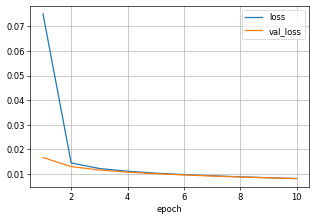

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['loss','val_loss'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()


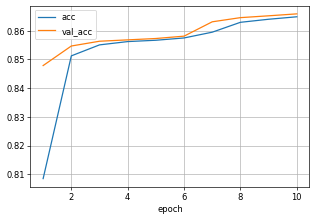

In [ ]:

# GRAFICAMOS LOS RESULTADOS DEL APRENDIZAJE
# =========================================

import matplotlib.pyplot as plt

fig = plt.figure(dpi=60)
#fig = plt.figure(figsize=(10,6))
ax  = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', y=['acc','val_acc'], grid=True, ax=ax)
#lt.ylim([0,0.010])
plt.show()


#Comprobamos con alguno de los grid de las simulaciones, la detección de los **agentes mutantes**.


<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Salida_1.png?raw=true' width="880"/>
<figcaption>fig. 2: El procesamiento que realiza la red neuronal (<i>empleando una función de pérdida 'Cross Entropy Loss'</i>) proporciona una salida de 2 matrices en este caso (una por cada clase, y cuyo tamaño es el del grid). Por ello cada agente (pixel de la imagen que se le pasa a la red CNN) tiene asociados 2 valores. Para llevar a cabo la clasificación, tenemos que transformar los valores de salida en probabilidades. Para esto llevamos a cabo una <b>tranformación Softmax</b>, tal y como se ve en la imagen. Para obtener la clase de agente, bastará posteriormente con extraer el índice donde ocurre el mayor de los dos valores (<i>arg max = argumento máximo</i>). Esto permite generar la matriz final con la identidad estimada de los agentes (0: agente emocional, 1: agente traidor).</figcaption></center>
</figure>


In [ ]:

from sklearn.metrics import confusion_matrix

torch.set_printoptions(precision=2)

X_prueba, y_prueba = next(iter(dataloader['val']))
y_prediccion = model(X_prueba)

y_prob = torch.argmax(softmax(y_prediccion), axis=1)
y_prob[1]


tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:

y_prueba[1]


tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

#Hemos elegido uno de los casos en los que acierta la identidad de todos los agentes:

In [ ]:

confusion_matrix(y_prueba[1].flatten().numpy(), y_prob[1].flatten().numpy())


array([[78,  0],
       [ 0, 22]])

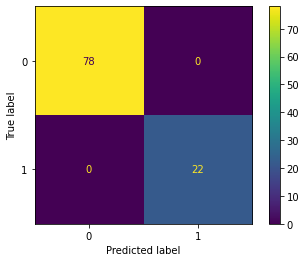

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay

# Agente emocional         --> código: 0
# Agente mutante (traidor) --> código: 1
# --------------------------------------
ConfusionMatrixDisplay.from_predictions(y_prueba[1].flatten().numpy(), y_prob[1].flatten().numpy())


#Ahora probamos con todos los píxeles de los frames (de 10x10) del conjunto de **DATOS de ENTRENAMIENTO**.

In [ ]:

from functools import reduce

predicciones_train  = []
observaciones_train = []

# Iteramos por el conjunto de datos de Validación
# -----------------------------------------------
for x_b, y_b in dataloader['train']:
  y_pred = model(x_b)
  y_prob = torch.argmax(softmax(y_pred), axis=1)
  # Se añaden como arrays a la lista, por lo que convertimos previamente a una lista
  # El resultado es una lista de lista, por lo que las reducimos a una sola más abajo
  # (Esto es así porque el procedimiento confusion_matrix sólo opera datos de 1 dimensión)
  predicciones_train.append(list(y_prob.numpy().flatten()))
  observaciones_train.append(list(y_b.numpy().flatten()))

data_pred_train = reduce(lambda a, b: a+b, predicciones_train)
data_obs_train  = reduce(lambda a, b: a+b, observaciones_train)

confusion_matrix(data_obs_train, data_pred_train)


array([[473630,  86681],
       [    25,  79664]])

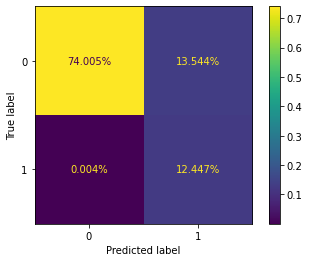

In [ ]:

ConfusionMatrixDisplay.from_predictions(data_obs_train, data_pred_train, normalize='all', values_format='.3%')


#Ahora probamos con todos los píxeles de los frames (de 10x10) del conjunto de **DATOS de VALIDACIÓN**.

In [ ]:

from functools import reduce

predicciones  = []
observaciones = []

# Iteramos por el conjunto de datos de Validación
# -----------------------------------------------
for x_b, y_b in dataloader['val']:
  y_pred = model(x_b)
  y_prob = torch.argmax(softmax(y_pred), axis=1)
  # Se añaden como arrays a la lista, por lo que convertimos previamente a una lista
  # El resultado es una lista de lista, por lo que las reducimos a una sola más abajo
  # (Esto es así porque el procedimiento confusion_matrix sólo opera datos de 1 dimensión)
  predicciones.append(list(y_prob.numpy().flatten()))
  observaciones.append(list(y_b.numpy().flatten()))

data_pred = reduce(lambda a, b: a+b, predicciones)
data_obs  = reduce(lambda a, b: a+b, observaciones)

confusion_matrix(data_obs, data_pred)



array([[118351,  21458],
       [     8,  20183]])

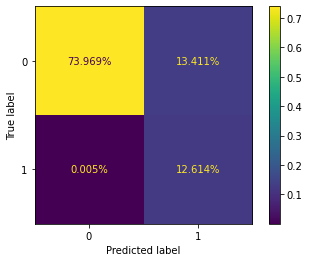

In [ ]:

ConfusionMatrixDisplay.from_predictions(data_obs, data_pred, normalize='all', values_format='.3%')


In [ ]:

import numpy as np

red    = '\033[91m'
green  = '\033[92m'
yellow = '\033[93m'
blue   = '\033[94m'
pink   = '\033[95m'
teal   = '\033[96m'
grey   = '\033[97m'
black  = '\x1b[0m'

#print(red + 'Hola' + blue + ' otra vez' + black + ' más')

matriz_obs = np.array([[0, 0, 1], [0, 1, 0], [0, 0, 0]])
#matriz_obs

matriz_pred = np.array([[0, 1, 1], [0, 1, 0], [1, 0, 0]])
#matriz_pred


Hola otra vez más


In [ ]:

# Una forma
red    = '\033[91m'
green  = '\033[92m'
blue   = '\033[94m'
grey   = '\033[97m'
black  = '\x1b[0m'

cadena = ''
size_m = 3

for i in range(size_m):
  for j in range(size_m):
    if (matriz_pred[i,j] != matriz_obs[i,j]) and (matriz_pred[i,j] == 1):
      cadena += red + str(matriz_pred[i,j]) + black + ' '
    elif (matriz_pred[i,j] == matriz_obs[i,j]) and (matriz_pred[i,j] == 1):
      cadena += green + str(matriz_pred[i,j]) + black + ' '
    else:
      cadena += str(matriz_pred[i,j]) + ' '
  cadena += '\n'

print(cadena)


0 1 1 
0 1 0 
1 0 0 



In [ ]:
matriz_obs

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 0]])

In [ ]:
matriz_pred

array([[0, 1, 1],
       [0, 1, 0],
       [1, 0, 0]])